In [1]:
import pandas as pd
import numpy as np
import re
import time
from datetime import datetime
import pickle as pkl
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
from sklearn import linear_model

# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, GaussianNoise, GRU, CuDNNGRU, Bidirectional, TimeDistributed, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

def evaluate(y_te, pred):
    print("mae: {:.4f}".format(mean_absolute_error(y_te, pred)))
    print("rmse: {:.4f}".format(mean_squared_error(y_te, pred)**(1/2)))
    print("me: {:.4f}".format((y_te-pred).mean()))

# Data Creation

In [2]:
df = pd.read_excel("data_processed.xlsx", sheet_name=0, header=0)

In [ ]:
indexes = np.unique(df['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [df['Study_Subject_Number'].values[index] for index in sorted(indexes)]

In [3]:
df.isnull().sum()

Study_Subject_Number          0
Order                         0
Age (yrs)                     0
Sex_M                         0
Sex_F                         0
Height (cm)                   0
Date                          0
SBP_start(mmHg)               0
SBP_End(mmHg)               107
Dry Weight                   47
Predialysis Weight            4
Post_dialysis Weight         99
Ultrafilteration Volume       3
Hct[Whole blood]              2
MCV[Whole blood]            114
MCHC[Whole blood]           114
MCH[Whole blood]            114
RDW[Whole blood]             52
MPV[Whole blood]             84
PLT Count[Whole blood]       89
WBC COUNT[Whole blood]        2
Calcium[Serum]               61
Inorganic P[Serum]           51
Glucose[Serum]               69
Total Protein[Serum]         49
Albumin[Serum]               46
Creatinine[Serum]            40
Uric Acid[Serum]             76
Serum Iron[Serum]          3787
URR[Serum]                 2430
EPO_Dose                      0
Hemoglob

### Remove Date

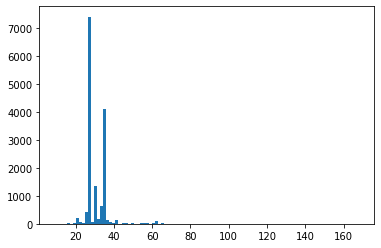

In [4]:
plt.hist(df['Date_diff'].values, bins = 100)
plt.show()

df['Date_diff'][df['Date_diff']>100]

df['Study_Subject_Number'][df['Date_diff']>100]

df = df[df['Study_Subject_Number']!='D-036']
df = df[df['Study_Subject_Number']!='D-042']
df = df[df['Study_Subject_Number']!='D-044']
df = df[df['Study_Subject_Number']!='F-037']
df = df[df['Study_Subject_Number']!='A-139']

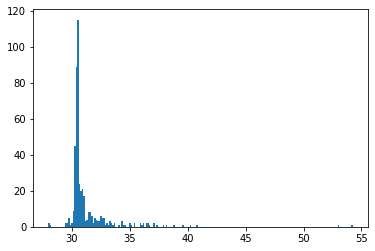

In [5]:
plt.hist(df.groupby('Study_Subject_Number')['Date_diff'].mean(), bins=200)
plt.show()

df.groupby('Study_Subject_Number')['Date_diff'].mean()[df.groupby('Study_Subject_Number')['Date_diff'].mean() > 45]

df = df[df['Study_Subject_Number']!='A-167']
df = df[df['Study_Subject_Number']!='E-024']

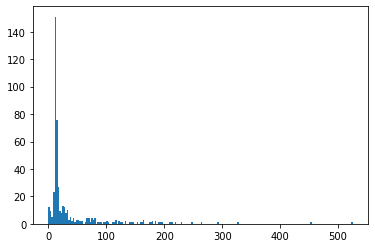

In [6]:
plt.hist(df.groupby('Study_Subject_Number')['Date_diff'].var(), bins=200)
plt.show()

df.groupby('Study_Subject_Number')['Date_diff'].var()[df.groupby('Study_Subject_Number')['Date_diff'].var() > 400]

df = df[df['Study_Subject_Number']!='A-043']
df = df[df['Study_Subject_Number']!='D-096']

In [7]:
target_var = ['Target_Hb']

info_vars = ['Study_Subject_Number', 'Order'] 

categoryA = ["Hemoglobin[Whole blood]", "Delta_Hb", "RDW[Whole blood]", "MCV[Whole blood]", "MCH[Whole blood]", "MCHC[Whole blood]", "Serum Iron[Serum]", "Age (yrs)", "Sex_M", "Sex_F", 'EPO_Dose']

categoryB = ["URR[Serum]", 'Dry Weight', 'Albumin[Serum]', 'Predialysis Weight', 'Height (cm)']

trn_vars = categoryA + categoryB

all_vars = info_vars + trn_vars + target_var

In [8]:
indexes = np.unique(df['Study_Subject_Number'].values, return_index=True)[1]
patient_list = [df['Study_Subject_Number'].values[index] for index in sorted(indexes)]

In [9]:
len(patient_list)

457

In [9]:
def data_generation(data, patient_list, seq_len, trn_scaler=None, trg_scaler=None):

    seq_set = []
    patient_set = []
    
    for p in tqdm(patient_list):
        record_len = len(data[data['Study_Subject_Number'] == p])
        for i in range(seq_len, record_len+1):
            if i<= record_len:
                seq_idx = data[data['Study_Subject_Number'] == p].index[i-seq_len:i].values
                seq_order = data['Order'][data['Study_Subject_Number'] == p].iloc[i-seq_len:i].values

                seq_set.append(seq_idx)
                patient_set.append(seq_order)
                
    if trn_scaler:
        data_matrix = trn_scaler.transform(data[trn_vars])
    else:
        data_matrix = data[trn_vars].values
        
    if trg_scaler:
        label = trg_scaler.transform(data[target_var])
    else:
        label = data[target_var].values

    x_data = np.array([data_matrix[seq] for seq in seq_set])
    y_data = np.array([label[seq][-1] for seq in seq_set])
    patient_set = np.array(patient_set)
    
    return x_data, y_data, patient_set

In [10]:
seqences_we_want = [1,2,3,4,5,6]
seed = 0

# Pure Data

In [11]:
pure_to_be_saved = pd.DataFrame()
patient_list_wo_na = []
for p in patient_list:
    temp = df[df['Study_Subject_Number']==p]
    if sum(temp.isnull().sum())==0:
        patient_list_wo_na.append(p)
        pure_to_be_saved = pd.concat([pure_to_be_saved, temp])
data_pure = pure_to_be_saved[all_vars]
data_pure.to_excel("Anemia_Pure.xlsx", index=False)

In [12]:
len(patient_list_wo_na)

86

In [13]:
train_patient_pure, test_patient_pure = train_test_split(patient_list_wo_na, test_size = 0.2, random_state=seed)
valid_patient_pure, test_patient_pure = train_test_split(test_patient_pure, test_size = 0.5, random_state=seed)

In [14]:
print('Train:', len(train_patient_pure))
print('Valid:', len(valid_patient_pure))
print('Test:', len(test_patient_pure))

In [ ]:
trn_idx = []
for p in train_patient_pure:
    trn_idx.extend(df_mean[df_mean['Study_Subject_Number']==p].index.values)

In [ ]:
trn_scaler_pure = StandardScaler().fit(data_pure[trn_vars].iloc[trn_idx])
with open('./trn_scaler_pure.pkl','wb') as f:
    pkl.dump(trn_scaler_pure, f)

hb_scaler_pure = StandardScaler().fit(data_pure[target_var].iloc[trn_idx])
with open('./hb_scaler_pure.pkl','wb') as f:
    pkl.dump(hb_scaler_pure, f)

In [16]:
for seq_len in seqences_we_want:
    
    x_train, y_train, order_train_pure = data_generation(df, train_patient_pure, seq_len, scaler_pure)
    x_valid, y_valid, order_valid_pure = data_generation(df, valid_patient_pure, seq_len, scaler_pure)
    x_test, y_test, order_test_pure = data_generation(df, test_patient_pure, seq_len, scaler_pure)
    
    print('Seq Len:', seq_len, '|', len(train_patient_pure), len(valid_patient_pure), len(test_patient_pure))
    print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))
    
    with open('./pure_'+str(seq_len)+'.pkl','wb') as f:
        pkl.dump([[x_train,y_train, order_train_pure],[x_valid,y_valid, order_valid_pure],[x_test,y_test, order_test_pure]], f)

# Mean Imputation

In [13]:
df_mean = df[all_vars].copy()
df_mean.index = list(range(len(df_mean)))

In [14]:
start = time.time()
variable_mean = df_mean.mean()
for p in patient_list:
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(method='ffill') # fill all below
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(method='bfill') # fill all above
    df_mean[df_mean['Study_Subject_Number']==p] = df_mean[df_mean['Study_Subject_Number']==p].fillna(value = variable_mean) # fill with mean if none exists
print(time.time()-start) # 15.924424648284912

df_mean[all_vars].to_excel("Anemia_MEAN.xlsx", index=False)

14.193015813827515


In [15]:
train_patient_mean, test_patient_mean = train_test_split(patient_list, test_size = 0.2, random_state=seed)
valid_patient_mean, test_patient_mean = train_test_split(test_patient_mean, test_size = 0.5, random_state=seed)

In [16]:
print('Train:', len(train_patient_mean))
print('Valid:', len(valid_patient_mean))
print('Test:', len(test_patient_mean))

Train: 365
Valid: 46
Test: 46


In [21]:
# Train: 372
# Valid: 47
# Test: 47

In [22]:
trn_idx = []
for p in train_patient_mean:
    trn_idx.extend(df_mean[df_mean['Study_Subject_Number']==p].index.values)

In [23]:
trn_scaler_mean = StandardScaler().fit(df_mean[trn_vars].iloc[trn_idx])
with open('./trn_scaler_mean_classifier.pkl','wb') as f:
    pkl.dump(trn_scaler_mean, f)

hb_scaler_mean = StandardScaler().fit(df_mean[target_var].iloc[trn_idx])
with open('./hb_scaler_mean_classifier.pkl','wb') as f:
    pkl.dump(hb_scaler_mean, f)

In [24]:
for seq_len in seqences_we_want:
    
    x_train, y_train, order_train_mean = data_generation(df_mean, train_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
    x_valid, y_valid, order_valid_mean = data_generation(df_mean, valid_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)
    x_test, y_test, order_test_mean = data_generation(df_mean, test_patient_mean, seq_len, trn_scaler_mean, hb_scaler_mean)  
    
    print('Seq Len:', seq_len, '|', len(order_train_mean), len(order_valid_mean), len(order_test_mean))
    print(np.mean(x_train),np.mean(x_valid),np.mean(x_test))

    with open('./mean1_'+str(seq_len)+'.pkl','wb') as f:
        pkl.dump([[x_train,y_train, order_train_mean],[x_valid,y_valid, order_valid_mean],[x_test,y_test, order_test_mean]], f)

100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.61it/s]


Seq Len: 1 | 11905 1607 1427
2.1426698205617468e-16 0.010053204386681159 0.022461285759866594


100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.89it/s]


Seq Len: 2 | 11540 1561 1381
0.0005188433198703588 0.010919453902401746 0.023464539942196567


100%|██████████████████████████████████| 46/46 [00:02<00:00, 12.16it/s]


Seq Len: 3 | 11175 1515 1335
0.0014592547223939933 0.012005632612291242 0.024823530733559716


100%|██████████████████████████████████| 46/46 [00:02<00:00, 12.64it/s]


Seq Len: 4 | 10812 1469 1289
0.0022267553726570896 0.013330972838065669 0.02579932087923073


100%|██████████████████████████████████| 46/46 [00:02<00:00, 12.79it/s]


Seq Len: 5 | 10450 1424 1243
0.0029926301964289695 0.01426557975676836 0.026590596879554035


100%|██████████████████████████████████| 46/46 [00:02<00:00, 17.22it/s]


Seq Len: 6 | 10097 1379 1199
0.003554995449307937 0.01513009925625881 0.027250925180963146


In [ ]:
# 100%|████████████████████████████████| 365/365 [00:26<00:00, 14.26it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.04it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.61it/s]
# Seq Len: 1 | 11905 1607 1427
# 2.1426698205617468e-16 0.010053204386681159 0.022461285759866594
# 100%|████████████████████████████████| 365/365 [00:25<00:00, 14.74it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.34it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.89it/s]
# Seq Len: 2 | 11540 1561 1381
# 0.0005188433198703588 0.010919453902401746 0.023464539942196567
# 100%|████████████████████████████████| 365/365 [00:24<00:00, 15.18it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.59it/s]
# 100%|██████████████████████████████████| 46/46 [00:02<00:00, 12.16it/s]
# Seq Len: 3 | 11175 1515 1335
# 0.0014592547223939933 0.012005632612291242 0.024823530733559716
# 100%|████████████████████████████████| 365/365 [00:24<00:00, 15.78it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 11.93it/s]
# 100%|██████████████████████████████████| 46/46 [00:02<00:00, 12.64it/s]
# Seq Len: 4 | 10812 1469 1289
# 0.0022267553726570896 0.013330972838065669 0.02579932087923073
# 100%|████████████████████████████████| 365/365 [00:23<00:00, 16.27it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 12.17it/s]
# 100%|██████████████████████████████████| 46/46 [00:02<00:00, 12.79it/s]
# Seq Len: 5 | 10450 1424 1243
# 0.0029926301964289695 0.01426557975676836 0.026590596879554035
# 100%|████████████████████████████████| 365/365 [00:22<00:00, 16.92it/s]
# 100%|██████████████████████████████████| 46/46 [00:03<00:00, 12.62it/s]
# 100%|██████████████████████████████████| 46/46 [00:02<00:00, 17.22it/s]
# Seq Len: 6 | 10097 1379 1199
# 0.003554995449307937 0.01513009925625881 0.027250925180963146